# Table of Contents
## Setup and Imports
    - Load libraries, set database paths, and connect to SQLite.
## Load Demolitions and Shelter Data
    - Pull fact tables, map job types and ownership.
## Basic Aggregations and Borough Analysis
    - Summarize demolitions, construction, and time-to-completion by borough and ownership.
## Proportions & ANOVA Tests
    – Compare demolition proportions across boroughs and between private/affordable using ANOVA and t-tests.
## Time Series: Demolitions and Shelter Counts
    – Monthly counts of affordable demolitions and shelter populations, merge for correlation.
## Visualizations
    – Line plots for demolitions, affordable demolitions, shelter trends, and correlation heatmaps.
## Construction vs Demolition (Affordable Housing)
    – Monthly construction and demolition counts, net units, and correlation with shelter counts.

In [20]:
# ================================
# Setup and Imports
# ================================
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import plotly.express as px

DB_PATH = '/Users/beans/Desktop/TeamHousing/data/processed/nyc_demolitions.db'
HOUSING_PATH = '/Users/beans/Desktop/TeamHousing/data/HousingDB_post2010.csv'

# Connect to database
conn = sqlite3.connect(DB_PATH)

In [21]:
# Load fact tables for analysis
query_owner_demo = """
SELECT *
FROM fact_demolitions
WHERE month_date BETWEEN '2016-01-01' AND '2023-01-01'
"""
fact_owner_demo = pd.read_sql_query(query_owner_demo, conn)

query_shelter = """
SELECT *
FROM fact_shelters
WHERE report_date BETWEEN '2016-01-01' AND '2023-01-01'
"""
fact_shelter = pd.read_sql_query(query_shelter, conn)

conn.close()

# Map job types and ownership
fact_owner_demo['job_typeid'] = fact_owner_demo['job_typeid'].map({1:'construction',2:'demolition'})
fact_owner_demo['ownership_id'] = fact_owner_demo['ownership_id'].map({1:'private',2:'affordable',3:'affordable'})

In [22]:
# Aggregation by ownership and job type
boroughagg = fact_owner_demo.groupby(['ownership_id','job_typeid']).agg(
    total_jobs=('month_date','count'),
    avg_time_completion=('time_of_completion','mean')
).reset_index()
display(boroughagg)

# Borough-level demolition stats
demolitions = fact_owner_demo[fact_owner_demo['job_typeid']=='demolition']
demolitions.groupby('borough').agg({'time_of_completion':'mean'})

# Count demolitions by borough & ownership
boroughwork = fact_owner_demo.groupby(['job_typeid','ownership_id','borough']).agg({'bin':'count'}).reset_index()
display(boroughwork)

,ownership_id,job_typeid,total_jobs,avg_time_completion
0,affordable,construction,618,1480.951456
1,affordable,demolition,286,145.160839
2,private,construction,8120,1555.096429
3,private,demolition,3312,218.054348


,job_typeid,ownership_id,borough,bin
0,construction,affordable,Bronx,68
1,construction,affordable,Brooklyn,416
2,construction,affordable,Manhattan,34
3,construction,affordable,Queens,83
4,construction,affordable,Staten Island,17
5,construction,private,Bronx,693
6,construction,private,Brooklyn,2508
7,construction,private,Manhattan,407
8,construction,private,Queens,2164
9,construction,private,Staten Island,2348


In [23]:
# Total buildings per ownership & borough
totalbuildings = boroughwork.groupby(['ownership_id','borough']).agg({'bin':'sum'}).reset_index()
# Total demolitions per ownership & borough
totaldemolitions = boroughwork[boroughwork['job_typeid']=='demolition'].reset_index()
list_totaldem = totaldemolitions['bin']
totalbuildings['totaldem'] = list_totaldem
totalbuildings['proportion'] = totalbuildings['totaldem'] / totalbuildings['bin']
totalbuildings.rename(columns={'bin':'totalbuildings'}, inplace=True)
display(totalbuildings)

# ANOVA for porportions across boroughs
# Null Hypothesis
borough_lists = totalbuildings.groupby('borough')['proportion'].apply(list).to_dict()
f_stat, p_value = f_oneway(
    borough_lists['Manhattan'],
    borough_lists['Bronx'],
    borough_lists['Brooklyn'],
    borough_lists['Queens'],
    borough_lists['Staten Island']
)
print("ANOVA p-value:", p_value)

# T-test: Private vs Affordable
from scipy import stats
affordable = totalbuildings[totalbuildings['ownership_id']=='affordable']
private = totalbuildings[totalbuildings['ownership_id']=='private']
ttest_result = stats.ttest_ind(private['proportion'], affordable['proportion'], equal_var=False, alternative='greater')
print("t-statistic:", ttest_result.statistic)
print("p-value:", ttest_result.pvalue)

,ownership_id,borough,totalbuildings,totaldem,proportion
0,affordable,Bronx,104,36,0.346154
1,affordable,Brooklyn,495,79,0.159596
2,affordable,Manhattan,42,8,0.190476
3,affordable,Queens,179,96,0.536313
4,affordable,Staten Island,84,67,0.797619
5,private,Bronx,1213,520,0.428689
6,private,Brooklyn,3457,949,0.274515
7,private,Manhattan,537,130,0.242086
8,private,Queens,3246,1082,0.333333
9,private,Staten Island,2979,631,0.211816


ANOVA p-value: 0.5564149366179449
t-statistic: -0.8662872452261037
p-value: 0.786364311297414


In [24]:
# Affordable demolitions per month
demo = fact_owner_demo[fact_owner_demo['job_typeid']=='demolition']
demo_affordable = demo[demo['ownership_id']=='affordable']
demo_affordable_ts = demo_affordable.groupby('month_date').agg({'job_typeid':'count'}).rename(columns={'job_typeid':'affordable_demo'}).reset_index()
demo_affordable_ts['month_date'] = pd.to_datetime(demo_affordable_ts['month_date'])

# Create full date range to fill missing months
all_months = pd.date_range(start='2016-01-01', end='2022-12-01', freq='MS')
datedf = pd.DataFrame({'month_date': all_months}).merge(demo_affordable_ts, how='left', on='month_date').fillna(0)
datedf['month_date'] = pd.to_datetime(datedf['month_date'])

# Merge with shelter data
fact_shelter['report_date'] = pd.to_datetime(fact_shelter['report_date'])
shelter = fact_shelter.rename(columns={'report_date':'month_date'})
shelter['month_date'] = pd.to_datetime(shelter['month_date'])
datedf = datedf.merge(shelter, how='left', on='month_date').fillna(0)

# Correlation
datedf.set_index('month_date', inplace=True)
print(datedf.corr())

# is saying as there are more affordable_demo, there is less shelter count (against our point)

                 affordable_demo  shelter_count
affordable_demo          1.00000       -0.12587
shelter_count           -0.12587        1.00000


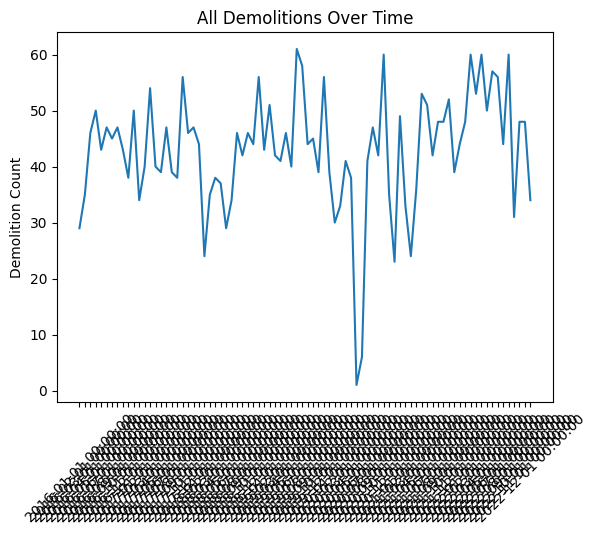

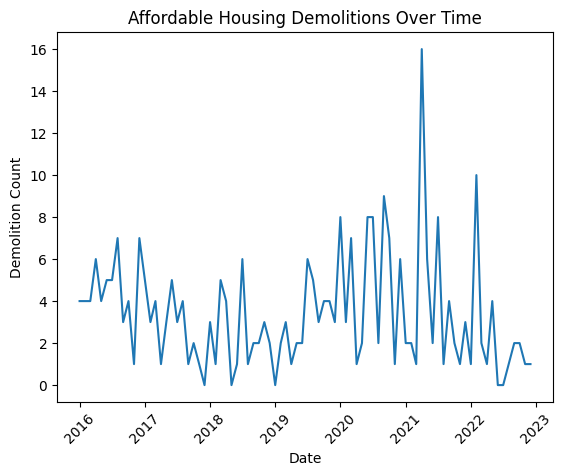

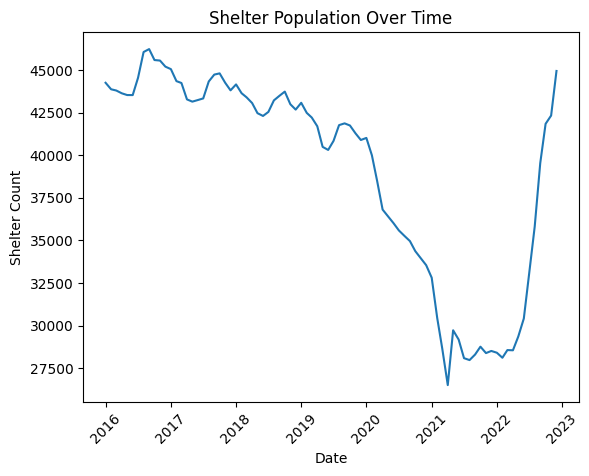

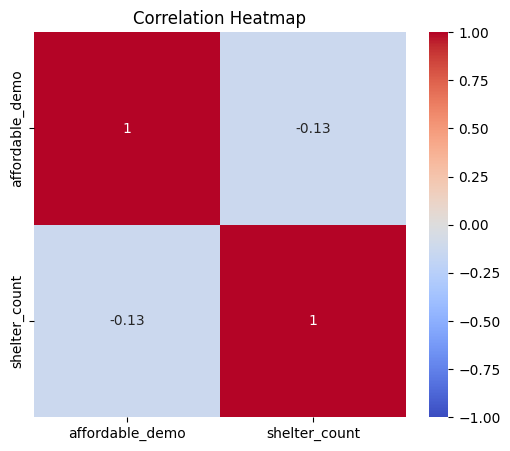

In [ ]:
# Demolitions over time
plt.figure()
demoeda = demo.groupby('month_date').agg({'job_typeid':'count'})
plt.plot(demoeda.index, demoeda['job_typeid'])
plt.title("All Demolitions Over Time")
plt.ylabel("Demolition Count")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()

# Affordable demolitions over time
plt.figure()
plt.plot(datedf.index, datedf['affordable_demo'])
plt.title("Affordable Housing Demolitions Over Time")
plt.ylabel("Demolition Count")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()

# Shelter population trend
plt.figure()
plt.plot(datedf.index, datedf['shelter_count'])
plt.title("Shelter Population Over Time")
plt.ylabel("Shelter Count")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(datedf.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [26]:
# Counts of construction and demolition per month
affordabledata = fact_owner_demo[fact_owner_demo['ownership_id']=='affordable']
affordabledata['month_date'] = pd.to_datetime(affordabledata['month_date'])
affordabledata_grouped = affordabledata.groupby(['month_date','job_typeid']).agg({'bin':'count'}).reset_index()

# Separate construction and demolition
construction = affordabledata_grouped[affordabledata_grouped['job_typeid']=='construction'].rename(columns={'bin':'construction'}).drop('job_typeid',axis=1)
demolition = affordabledata_grouped[affordabledata_grouped['job_typeid']=='demolition'].rename(columns={'bin':'demolition'}).drop('job_typeid',axis=1)

# Merge and calculate net
affdemocount = construction.merge(demolition, how='left', on='month_date').fillna(0)
affdemocount['net'] = affdemocount['construction'] - affdemocount['demolition']

# Merge with shelter counts
affdcs = datedf.merge(affdemocount, how='left', on='month_date').fillna(0)

# Correlation check
print(affdcs.corr())

                 month_date  affordable_demo  shelter_count  construction  \
month_date         1.000000        -0.057307      -0.793206     -0.223147   
affordable_demo   -0.057307         1.000000      -0.125870     -0.037405   
shelter_count     -0.793206        -0.125870       1.000000      0.208179   
construction      -0.223147        -0.037405       0.208179      1.000000   
demolition        -0.057999         0.996331      -0.124309     -0.024131   
net               -0.184802        -0.397005       0.237319      0.931509   

                 demolition       net  
month_date        -0.057999 -0.184802  
affordable_demo    0.996331 -0.397005  
shelter_count     -0.124309  0.237319  
construction      -0.024131  0.931509  
demolition         1.000000 -0.386091  
net               -0.386091  1.000000  


/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_20628/2290579524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  affordabledata['month_date'] = pd.to_datetime(affordabledata['month_date'])
